# LangChain: Q&A over Documents

An example might be a tool that would allow you to query a product catalog for items of interest.

In [1]:
#pip install --upgrade langchain

In [2]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

Note: LLM's do not always produce the same results. When executing the code in your notebook, you may get slightly different answers that those in the video.

In [3]:
# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"

In [5]:
# For retrieval over some docs
from langchain.chains import RetrievalQA
# llm
from langchain.chat_models import ChatOpenAI
# Document Loader - We use it ot load some proprietary data that we will combine with the language model
# Here we are uploading a csv file so we are using CSVLoader
from langchain.document_loaders import CSVLoader
# For vector store - DocArrayInMemorySearch
# This is an In Memory Search Vector storage, so doesnt require connecting to an external database.
from langchain.vectorstores import DocArrayInMemorySearch
# Common utilities to display information in jupyter notebook
from IPython.display import display, Markdown

In [6]:
file = 'OutdoorClothingCatalog_1000.csv'
loader = CSVLoader(file_path=file)

In [7]:
# helps us create a vector storage very easily
from langchain.indexes import VectorstoreIndexCreator

In [8]:
#pip install docarray

In [9]:
# from_loaders - takes in a list of document loaders
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

In [10]:
query ="Please list all your shirts with sun protection \
in a table in markdown and summarize each one."

In [11]:
response = index.query(query)

In [12]:
display(Markdown(response))



| Name | Description |
| --- | --- |
| Men's Tropical Plaid Short-Sleeve Shirt | UPF 50+ rated, 100% polyester, wrinkle-resistant, front and back cape venting, two front bellows pockets |
| Men's Plaid Tropic Shirt, Short-Sleeve | UPF 50+ rated, 52% polyester and 48% nylon, machine washable and dryable, front and back cape venting, two front bellows pockets |
| Men's TropicVibe Shirt, Short-Sleeve | UPF 50+ rated, 71% Nylon, 29% Polyester, 100% Polyester knit mesh, machine wash and dry, front and back cape venting, two front bellows pockets |
| Sun Shield Shirt by | UPF 50+ rated, 78% nylon, 22% Lycra Xtra Life fiber, handwash, line dry, wicks moisture, fits comfortably over swimsuit, abrasion resistant |

All four shirts provide UPF 50+ sun protection, blocking 98% of the sun's harmful rays. The Men's Tropical Plaid Short-Sleeve Shirt is made of 100% polyester and is wrinkle-resistant

# Embeddings and Vector Storage

LM's can inspect only few thousand words at a time. 

So if we have really large docs, how can we get the LM to answer questions about everything that is in there?

Sol: Embeddings and Vector Storage

Embeddings: Numerical representations for pieces of text.
            This captures the semantic meaning of the piece of text.
            Pieces of text with similar content have similar vectors.
            This lets us compare peices of text in vector space.

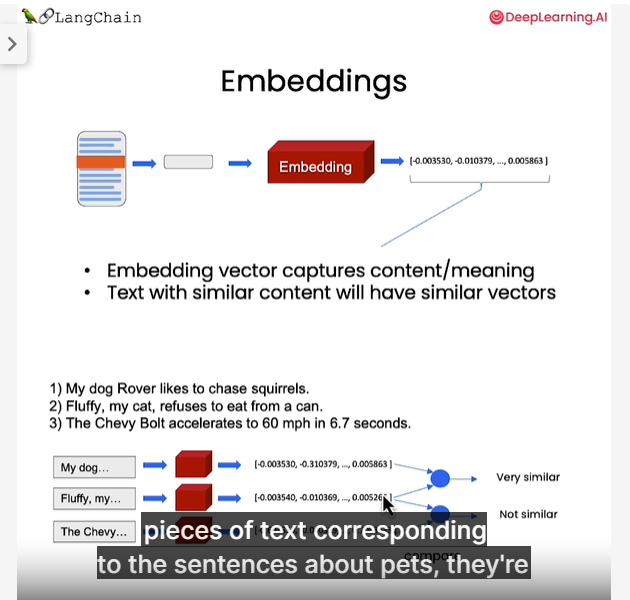

The similarity factor helps of us understand which pieces of text we want to include when passing to the language model.


#### Vector Database: 

More than 80% of data is Unstructure data(Images, video, audio, social media posts etc).

Instead of storing these in an RDBMS by writing TAGS for these images etc to categorize them we can use Vector Database and Vector Embeddings.

Vector Embeddings help in Fast Retrieval and Similarity Search.

**Unstructured Data -> Model -> Vector Embeddings

*Vector Embedding:*  
A list of nums[0.1, 0.3, 0.8,0.9....] that represents data in a     different way.

V.E can be for a word, sentence, image etc

These vectors can be understood by the computer so we can find nearest neighbors by calculating distances.

BUT performing calc amg 1000s of vectors is a v.slow process

Hence we index these vectors

Index = A data Structure which facilitates the search process.

Indexing maps the vectors to a new data structure that enables faster searching.

#### Vector Database for LLM: 
We populate the database with chunks coming from the incoming documents.  
                 
This helps in creating pieces of text that are smaller than the original document which is useful because we may not be able to  pass the whole document to the LM.

We only pass the relative peices to the LM.

We now create embdding for each of these chunks and we store those in a vector database.( Indexing is involved in this too).

During runtime indexing helps us find these peices of text which is most relevant to the incoming query.

When a query comes in we first create an embedding for that query, compare it with all the queries in the vector database and pick the most similar embeddings.
                 
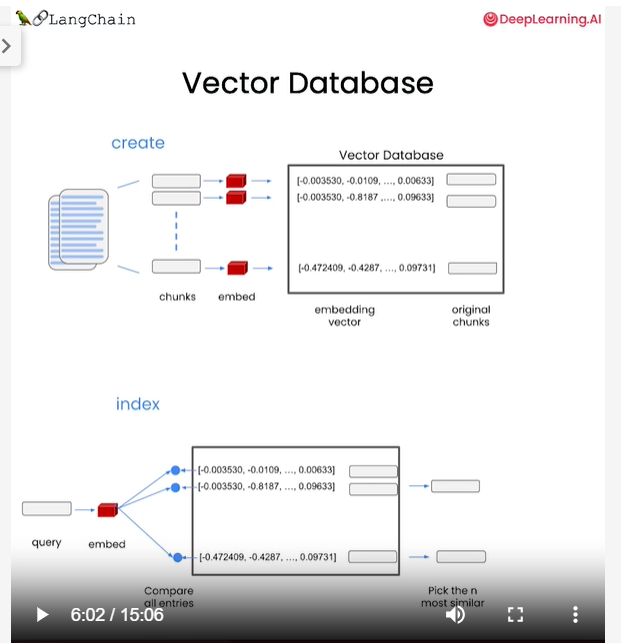

These are returned and we can pass those in the prompt for the LM to get the final answer. 

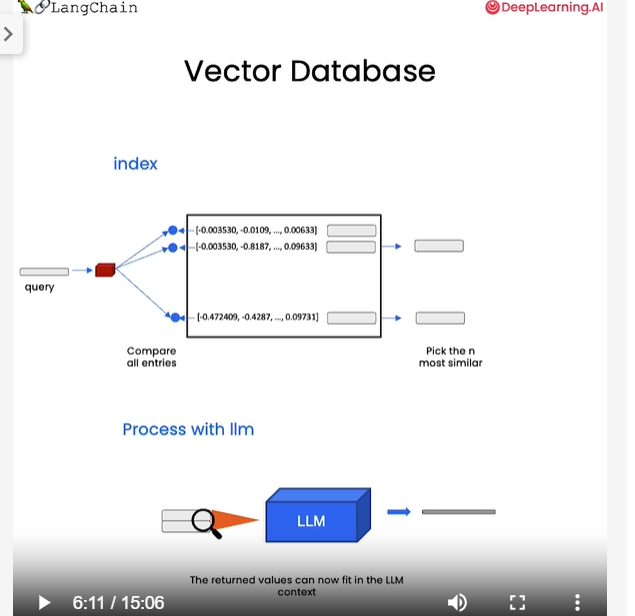

Examples of Vector Databases: FAISS, PineCone, Chrome DB, Redis

## Step By Step

In [13]:
from langchain.document_loaders import CSVLoader
loader = CSVLoader(file_path=file)

In [14]:
docs = loader.load()

In [15]:
docs[0]

Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 0})

In [17]:
#These docs are already small hence we dont need to performing chunking and can create EMbeddings directly using OpenAI' Embedding class.
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [18]:
embed = embeddings.embed_query("Hi my name is Harrison")

In [19]:
print(len(embed))

1536


In [20]:
print(embed[:5])

[-0.021867522969841957, 0.006806864403188229, -0.01818099617958069, -0.03910486772656441, -0.014066680334508419]


In [21]:
# from_documents() is for creating embeddings for all pieces of text we just loaded and then store them in a vector store 
# Takes in the pieces of text, an embedding object and then crates an overall vector store( a type of database that stores and retrieves high-dimensional numerical vectors)
db = DocArrayInMemorySearch.from_documents(
    docs, 
    embeddings
)

In [22]:
query = "Please suggest a shirt with sunblocking"

In [23]:
docs = db.similarity_search(query)

In [24]:
len(docs)

4

In [25]:
docs[0]

Document(page_content=': 255\nname: Sun Shield Shirt by\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \n\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\n\nFabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.\n\nAdditional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.\n\nSun Protection That Won\'t Wear Off\nOur high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun\'s harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.', metadata={'source': 'OutdoorClothingCatalog_1000.csv', 'row': 255})

## Using this technique with an LLM

To use the above technique for Question Answering we create a Retriever from this vector store.

### Retriever

A retriever is a generic interface that can be underpinned by any method that takes in a query and returns documents.
Vector Stores and Embeddings are one such method to do so although there are many others too.

In [26]:
retriever = db.as_retriever()

Since we want to do TEXT GENERATION and return Natural Language Response, we are going to import the ChatOpenAI's LM.

In [27]:
llm = ChatOpenAI(temperature = 0.0, model=llm_model)

Next we combine the docs into a single piece of text and store them in a variable, which is nothing but the next step.

In [28]:
qdocs = "".join([docs[i].page_content for i in range(len(docs))])


Now we pass the variable or variant of question into the LLM.

In [29]:
response = llm.call_as_llm(f"{qdocs} Question: Please list all your \
shirts with sun protection in a table in markdown and summarize each one.") 


In [30]:
display(Markdown(response))

| Name | Description |
| --- | --- |
| Sun Shield Shirt | High-performance sun shirt with UPF 50+ sun protection, moisture-wicking, and abrasion-resistant fabric. Fits comfortably over swimsuits. Recommended by The Skin Cancer Foundation. |
| Men's Plaid Tropic Shirt | Ultracomfortable shirt with UPF 50+ sun protection, wrinkle-free fabric, and front/back cape venting. Made with 52% polyester and 48% nylon. |
| Men's TropicVibe Shirt | Men's sun-protection shirt with built-in UPF 50+ and front/back cape venting. Made with 71% nylon and 29% polyester. |
| Men's Tropical Plaid Short-Sleeve Shirt | Lightest hot-weather shirt with UPF 50+ sun protection, front/back cape venting, and two front bellows pockets. Made with 100% polyester and is wrinkle-resistant. |

All of these shirts provide UPF 50+ sun protection, blocking 98% of the sun's harmful rays. They are made with high-performance fabrics that are moisture-wicking, abrasion-resistant, and/or wrinkle-free. Some have front/back cape venting for added comfort in hot weather. The Sun Shield Shirt is recommended by The Skin Cancer Foundation.

## Encapsulation

All the steps can be encapsulated with the LangChain chain.

So here we create a Retrieval QA Chain.

This does retrieval and does question answering over the retrieved docs.

To do this, we pass on the LM (for text generation at the end), chain type as "stuff" (simplest method that stuffs the documents into context and makes one call to an LM), Retreiver( to fetch the docs and sned it to the LM) and verbose=True.

1) Stuff method: Most common method for Question Answering over PDFs.

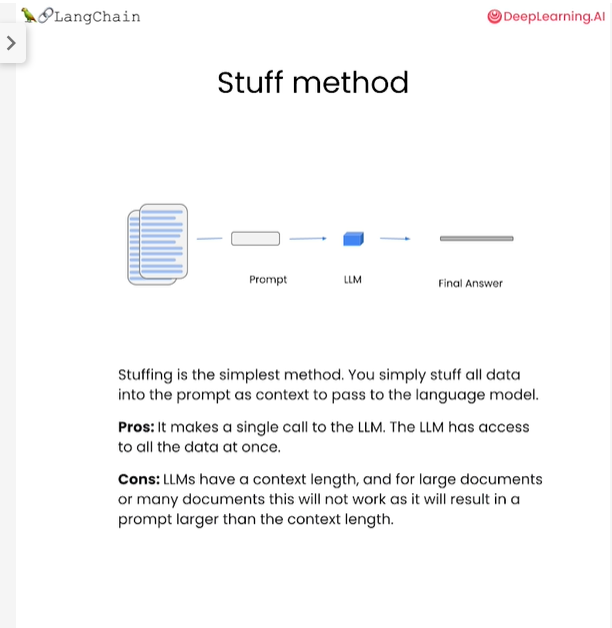

Here we have used STUFF chain type but doesnt always work well.

When we fetched the documents in the notebook, we only got 4 docs back and they are relatively very small.

## Q) What if we had to do same type of question answering over lots of different types of chuncks?

SOLUTION:

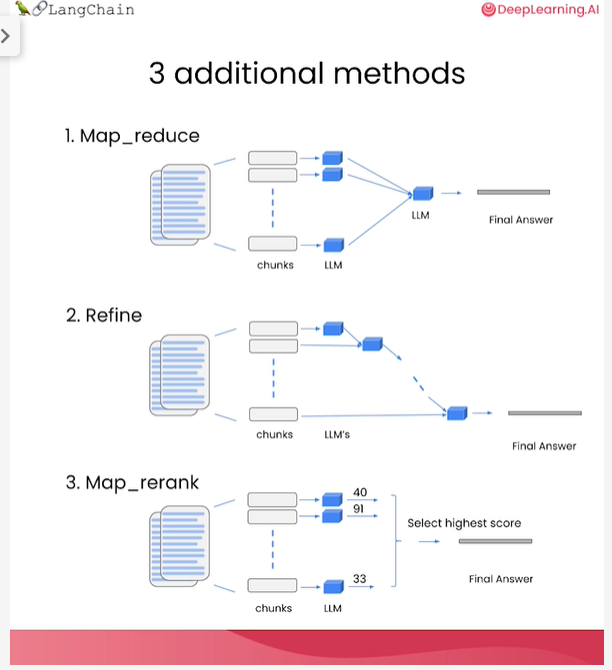

2) Map Reduce: Takes all the chunks, passes them all along with the question to an LM, gets a response back and then uses another LM call to summarize all the individual responses into a final answer. 

2nd most common method to use for Question Answering for PDFs.

MOst common method to use in Summarization of PDFs.

In this we can even do individual questions in parallel but will take lot more calls and will treat all the docs as independent which may not always be the moszt desired thing.

3) Refine: Used to loop over many documents iteratively i.e it builds upon the answer from the previous document.

This is really good for combining information and building up an answer over time. It will generally lead to a longer answer but, it is not fast as now all the calls arent independent( each depends on the previous calls).

So it takes same number of calls as map reduce but will take more time when comapred to it.

4) Map Re-Rank: In this we do a single call to the LM for each document and ask it to return a score, from where we select the highest score.

So we rely on the LM to know what the score should be, so we have to communicate that, 'It should be a really high score if it is relevant to the document and really refine the instructions there.

Similar to Map Reduce all the calls are independent, so we can batch them and is relatively fast but we are making a bunch of LM calls, which is a bit more expensive.

More of an experimental model but is interesting to use.

In [31]:
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True
)

In [32]:
query =  "Please list all your shirts with sun protection in a table \
in markdown and summarize each one."

In [33]:
response = qa_stuff.run(query)



> Entering new RetrievalQA chain...

> Finished chain.


In [34]:
display(Markdown(response))

| Shirt Number | Name | Description |
| --- | --- | --- |
| 618 | Men's Tropical Plaid Short-Sleeve Shirt | This shirt is made of 100% polyester and is wrinkle-resistant. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 374 | Men's Plaid Tropic Shirt, Short-Sleeve | This shirt is made with 52% polyester and 48% nylon. It is machine washable and dryable. It has front and back cape venting, two front bellows pockets, and is rated to UPF 50+. |
| 535 | Men's TropicVibe Shirt, Short-Sleeve | This shirt is made of 71% Nylon and 29% Polyester. It has front and back cape venting that lets in cool breezes and two front bellows pockets. It is rated UPF 50+ for superior protection from the sun's UV rays. |
| 255 | Sun Shield Shirt | This shirt is made of 78% nylon and 22% Lycra Xtra Life fiber. It is handwashable and line dry. It is rated UPF 50+ for superior protection from the sun's UV rays. It is abrasion-resistant and wicks moisture for quick-drying comfort. |

All of these shirts provide UPF 50+ sun protection, blocking 98% of the sun's harmful rays. They are all designed to be lightweight and comfortable in hot weather. They all have front and back cape venting that lets in cool breezes and two front bellows pockets. The Men's Tropical Plaid Short-Sleeve Shirt is made of 100% polyester and is wrinkle-resistant. The Men's Plaid Tropic Shirt, Short-Sleeve is made with 52% polyester and 48% nylon. The Men's TropicVibe Shirt, Short-Sleeve is made of 71% Nylon and 29% Polyester. The Sun Shield Shirt is made of 78% nylon and 22% Lycra Xtra Life fiber and is abrasion-resistant and wicks moisture for quick-drying comfort.

**THE ABOVE WHOLE TASK CAN BE DONE USING A SINGLE LINE TOO, but in the detailed process we can set more specifics:** 

In [35]:
#Using the One Line code
response = index.query(query, llm=llm)

We can also customize the embeddings, which gives us a flexibility over how the embeddings themselves are created and also swap out the Vector Store too( for a different type of vector store).

In [36]:
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeddings,
).from_loaders([loader])